This notebook visualises the images and draws predicted and target bounding boxes and sentences.

In [ ]:
import pickle
import torch
from PIL import Image, ImageDraw, ImageFont
import os
import os.path as osp
import random

In [ ]:
def load_data(model,mode, dataset, split,full=True):
#load predicted and gold bounding boxes

    try:
        if full==False:
            with open(r"/home/users/fschreiber/project/bboxes_empty_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                pred_bbox_list=list(pickle.load(f)) 

            #the target bounding box
            with open(r"/home/users/fschreiber/project/bboxes_empty_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                target_bbox_list=list(pickle.load(f))   
        else:
            #the predicted bounding box
            with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                pred_bbox_list=list(pickle.load(f))

            if mode=="non_inc":
                #the target bounding box
                with open(r"/home/users/fschreiber/project/bboxes_noninc_"+model+"/"+dataset+"/"+split+"_pred_bbox_list.p","rb") as f:
                    target_bbox_list=list(pickle.load(f))

            elif mode == "inc":
                #the target bounding box
                with open(r"/home/users/fschreiber/project/bboxes_"+model+"/"+dataset+"/"+split+"_target_bbox_list.p","rb") as f:
                    target_bbox_list=list(pickle.load(f))
            else:
                print("The mode can only be non_inc or inc")
                return -1,-1,-1,-1,-1

        #the number of one sentence split up incrementally ("the left zebra" would have length 3)
        with open(r"/home/users/fschreiber/project/incremental_pickles/length_incremental_units/"+dataset+"_"+split+"_length_unit.p","rb") as f:
            inc_len=pickle.load(f)

        #the original model data split up incrementally
        data_model=torch.load("/home/users/fschreiber/project/ready_inc_data/"+dataset+"/"+dataset+"_"+split+".pth")

        with open(r"/home/users/fschreiber/project/binary_grouped/"+model+"/"+mode+"/"+dataset+split+".p","rb") as f:
            binary_grouped=pickle.load(f)

        
        if mode=="non_inc":
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]

        if full==False:
            pred_bbox_list=[x for x,y in zip(pred_bbox_list,inc_len) for _ in range(y)]
            target_bbox_list=[x for x,y in zip(target_bbox_list,inc_len) for _ in range(y)]

        if model=="TVG":
            pred_bbox_list,target_bbox_list=TVG_prep(pred_bbox_list,target_bbox_list)
                    

        return pred_bbox_list,target_bbox_list,inc_len,data_model,binary_grouped
    
    except FileNotFoundError as e:
        #print(e)
        
        return  -1,-1,-1,-1,-1
    


#TVG needs some extra adjustments to fit the same data format as Resc
def TVG_prep(pred_bbox_list,target_bbox_list):
    #print("TVG")
    for ind,(pred,targ) in enumerate (zip (pred_bbox_list,target_bbox_list)):

        pred=pred.view(1,-1)

        pred=xywh2xyxy(pred)
        pred=torch.clamp(pred,0,1)

        pred_bbox_list[ind]=pred

        targ=targ.view(1,-1)
        targ=xywh2xyxy(targ)

        target_bbox_list[ind]=targ
    return pred_bbox_list,target_bbox_list

#copied from TransVG needed to transform the bounding box vectors
def xywh2xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)


In [ ]:
#Load a dataset
pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped=load_data("ReSc","inc","unc","testB")


In [ ]:
#group sentences that belong to one incremental unit
def group_by_increment(bbox_list,inc_len):
    counter=0
    group_list=[]
    for i in inc_len:
        
        group_list.append(bbox_list[counter:counter+i])
        counter=counter+i
    return group_list


pred_group=group_by_increment(pred_bbox_list,inc_len)
targ_group=group_by_increment(target_bbox_list,inc_len)
model_group=group_by_increment(model,inc_len)

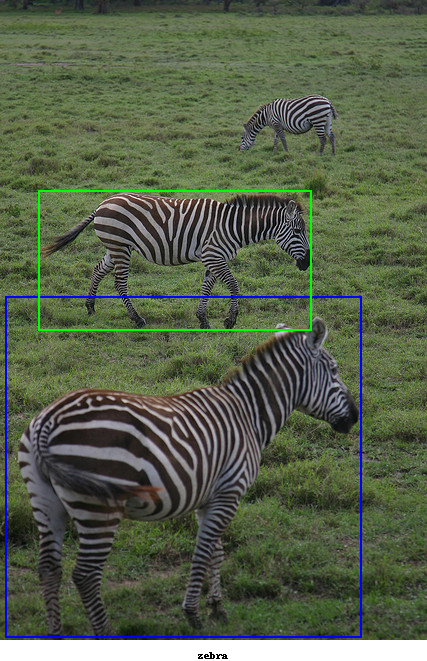

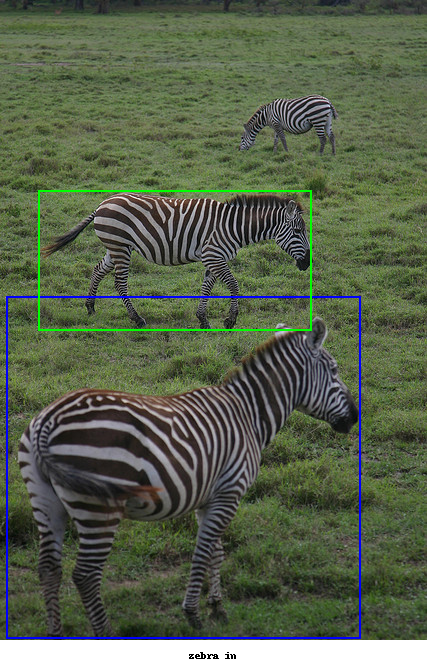

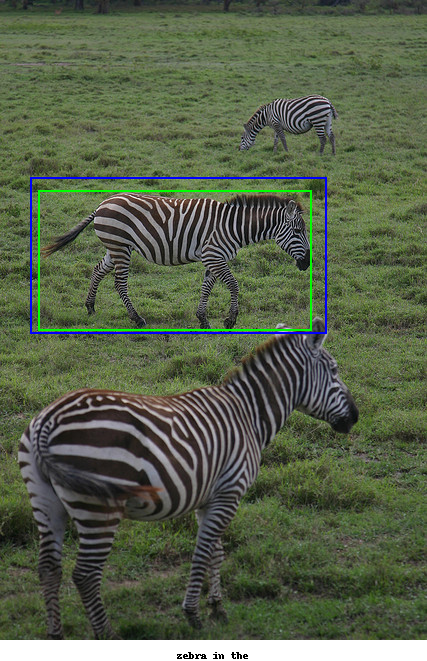

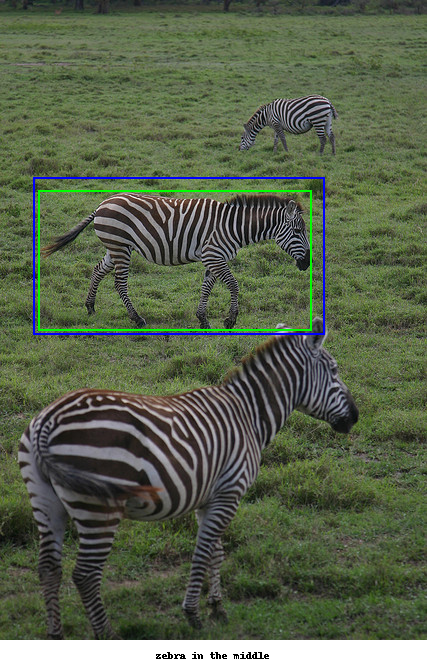

In [ ]:
#draws on complete sentence word wise 
#draws the predicted and target bounding boxes and sentence information
#n is the number of the image choosen
def vis_pic(pred_group,targ_group,model_group,n,dataset,split):

        example=pred_group[n]

        for i in range(len(example)):
                
                #number holds the image number and the increment number
                number=(n,i)
                
                path="/home/users/fschreiber/project/TransVG/ln_data/other/images/mscoco/images/train2014/"+model_group[number[0]][number[1]][0]

                #print(model_group[number[0]][number[1]][3])

                #get the prediction coordinates
                pred_all=[]
                pred_list=pred_group[number[0]][number[1]].tolist()
                pred_list = [item for sublist in pred_list for item in sublist]
                
                pred_all.append(pred_list)

                targ_list=targ_group[number[0]][number[1]].tolist()
                targ_list = [item for sublist in targ_list for item in sublist]


                # Load the image
                image = Image.open(path)

                
                draw = ImageDraw.Draw(image)

                #Target is green, prediction is blue
                outline_color_targ = (0, 255, 0)  
                outline_color_pred=(0,0,255)
                outline_width = 2 


                # Draw the bounding boxes on the image
                draw.rectangle([(pred_list[0], pred_list[1]), (pred_list[2], pred_list[3])], outline=outline_color_pred, width=outline_width)

                draw.rectangle([(targ_list[0], targ_list[1]), (targ_list[2], targ_list[3])], outline=outline_color_targ, width=outline_width)


                # Define the text to write
                text = model_group[number[0]][number[1]][3]

                # Define the font style and size and color
                font = ImageFont.load_default()
                text_color = (0, 0, 0)  

                # Define the text position (centered and under the image)
                #by drawing a box under the image
                bbox = draw.textbbox((0, 0), text, font=font)
                text_width = bbox[2] - bbox[0]
                text_height = bbox[3] - bbox[1]

                image_width, image_height = image.size

                text_position = ((image_width - text_width) // 2, image_height + 10)  

                new_image = Image.new('RGB', (image_width, image_height + text_height + 10), color=(255, 255, 255))
                new_image.paste(image, (0, 0))

                # create a new image with the added text information
                new_draw = ImageDraw.Draw(new_image)
                new_draw.text(text_position, text, font=font, fill=text_color)

                # Save or display the new image with the text
                new_image.show()


                #if not osp.isdir("/home/users/fschreiber/project/tmp_image_bboxes/exp"+str(n)):
                #        os.makedirs("/home/users/fschreiber/project/tmp_image_bboxes/exp"+str(n))
                
                #output_path = "/home/users/fschreiber/project/tmp_image_bboxes/exp"+str(n)+"/"+str(i)+"_.jpg"
                #new_image.save(output_path)


vis_pic(pred_group,targ_group,model_group,3,"unc","testB")

        

In [ ]:
#This function randomly samples on image of each split and save it
random.seed(0)

mode="inc"
model_input="ReSc"
split_list=["testB","testA","val","test"]
dataset_list=["unc","unc+","gref_umd","gref"]
#dataset_list=["unc"]

model_number=[]

for file in dataset_list:
    for split in split_list:
    
        pred_bbox_list,target_bbox_list,inc_len,model,binary_grouped= load_data(model_input,mode,file,split)

        #if the file is not found pass
        if pred_bbox_list==-1 or target_bbox_list==-1 or inc_len==-1:
             pass 
    
        else:
            print(file+split)
            
            group_list=[]
            pred_group=group_by_increment(pred_bbox_list,inc_len)
            targ_group=group_by_increment(target_bbox_list,inc_len)
            model_group=group_by_increment(model,inc_len)

            for count, value in enumerate(model_group):
                group_list.append((value[0][0],count))

            #randomly sample
            rand_group=random.sample(group_list,1)

            for i in rand_group:
                
                #draw bounding box into the image and add text information
                vis_pic(pred_group,targ_group,model_group,i[1],file,split)
            


unctestB
unctestA
uncval
unc+testB
unc+testA
unc+val
gref_umdval
gref_umdtest
grefval
